
# 보일러 효율 영향 인자 분석 v2
정확도 (accuracy)	 : 전체 중 맞춘 비율	
정밀도 (precision)	 : “고효율(1)”이라고 예측한 것 중 실제로 맞은 비율	
재현율 (recall)	     : 실제 고효율 중에서 모델이 맞게 찾아낸 비율
F1-score	        : 정밀도와 재현율의 조화 평균

In [8]:

FILE_PATTERN = './*.csv'        
EFF_COL = '효율(입출력법-스팀)'
EFF_FALLBACK_COL = '효율(순간)'
EFF_THRESHOLD = 94.5                    #고효율의 기준을 94.5%로 잡았음.

TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_ITER = 2000
HEAVY_MISSING_THRESHOLD = 0.80

import os, glob, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
warnings.filterwarnings('ignore')


In [ ]:

files = sorted(glob.glob(FILE_PATTERN))
if not files:
    raise FileNotFoundError(f'No CSV files found for pattern: {FILE_PATTERN}')

def read_csv_fallback(path):
    try:
        return pd.read_csv(path, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            return pd.read_csv(path, encoding='cp949')
        except UnicodeDecodeError:
            return pd.read_csv(path, encoding='euc-kr')

dfs, failed = [], []
for f in files:
    try:
        df_tmp = read_csv_fallback(f)
        df_tmp['__source_file__'] = os.path.basename(f)
        dfs.append(df_tmp)
    except Exception as e:
        print(f"[WARN] Failed to read {f}: {e}")
        failed.append((f, str(e)))

if not dfs:
    raise RuntimeError('No CSVs could be read. Check file encoding or format.')

df_raw = pd.concat(dfs, ignore_index=True)
print('Loaded rows:', len(df_raw), 'from files:', len(dfs))
if failed:
    print('Failed files (up to 3 shown):', failed[:3])

df_raw.head(3)


Loaded rows: 32438 from files: 1


,생성일,부하율,설정 압력,보일러 압력,송풍기 인버터 출력,송풍기 입력,급수 펌프,급수펌프 입력,가스 댐퍼,가스 댐퍼 입력,Air 댐퍼,Air 댐퍼 입력,재순환 댐퍼,재순환 외기 댐퍼,재순환 댐퍼 입력,재순환 외기 댐퍼 입력,급수 수위,보일러 온도,배기가스온도1,배기가스온도2,배기가스온도3,배기 재 순환 온도,에코 온도1,에코 온도2,버너온도,배기가스 NOx,배기가스 O2,재순환 O2,재순환 NOx,급수량(적산유량),급수량(순간유량),연료량(적산유량),연료량(순간유량),효율(순간),소비전류,진동센서1,진동센서2,운전시간,정상 운전 확률,송풍기 고장 확률,AIR 댐퍼 고장 확률,GAS 앰퍼 고장 확률,확률 업데이트 시간,순간 스팀량,입출력법 효율,열 손실법 효율,효율(입출력법-스팀),__source_file__
0,60.0,5.6,5.4,71.0,61.1,0.0,0,30.0,29.8,35.0,34.8,30.0,40.0,30.6,39.7,100.0,164.1,197.3,99.9,55.7,-,35.3,63.3,-,5.0,5.0,0,0,19834.52,1.34,1434993.0,96.1,84.43,30.02,0,0,15162:56,1.08,7.62,91.1,0.2,2025-06-10 09:28:01,2.2,56.54,94.60,138.75,NaN,28_2025-09-04.csv
1,60.0,5.6,5.4,71.0,61.2,75.0,0,30.0,30.1,35.0,34.8,30.0,40.0,30.5,39.8,70.0,164.1,197.4,99.8,55.7,-,35.2,63.3,-,4.0,5.1,0,0,19834.52,0.00,1434993.0,96.9,0.00,26.75,0,0,15162:56,1.08,7.62,91.1,0.2,2025-06-10 09:28:01,2.3,0.00,94.57,143.88,NaN,28_2025-09-04.csv
2,60.0,5.6,5.4,71.0,61.2,75.0,0,30.0,30.0,35.0,34.8,30.0,40.0,30.6,39.7,70.0,164.1,197.4,99.8,55.6,-,35.2,63.3,-,5.0,5.1,0,0,19834.52,0.38,1434993.0,96.7,23.88,30.82,0,0,15162:56,1.08,7.62,91.1,0.2,2025-06-10 09:28:01,2.3,15.93,94.57,144.18,NaN,28_2025-09-04.csv


In [ ]:

# === 전처리 ===
df = df_raw.copy()
df.columns = [str(c).strip() for c in df.columns]

# 공백은 Nan으로 변경
df = df.replace({'-': np.nan, '–': np.nan, '—': np.nan, '': np.nan, ' ': np.nan})

# 숫자형 변환
def to_numeric_safe(series):
    return pd.to_numeric(series.astype(str).str.replace(',', '', regex=False), errors='coerce')

# 문자열/시간 컬럼 후보 탐지
string_like_cols = set()
for col in df.columns:
    if df[col].dtype == 'object':
        sample = df[col].dropna().astype(str).head(20).tolist()
        if any((':' in s and not s.replace(':','').isdigit()) or ('-' in s and any(ch.isdigit() for ch in s)) for s in sample):
            string_like_cols.add(col)

df_num = df.copy()
for col in df.columns:
    if col not in string_like_cols:
        try:
            df_num[col] = to_numeric_safe(df[col])
        except Exception:
            pass

# 효율 컬럼 선택
eff_col_used = None
if EFF_COL in df_num.columns and df_num[EFF_COL].dropna().shape[0] > 0:
    eff_col_used = EFF_COL
elif EFF_FALLBACK_COL in df_num.columns and df_num[EFF_FALLBACK_COL].dropna().shape[0] > 0:
    eff_col_used = EFF_FALLBACK_COL
else:
    raise KeyError(f'효율 컬럼을 찾지 못했습니다. 후보: {EFF_COL}, {EFF_FALLBACK_COL}')
print('Using efficiency column:', eff_col_used)

# 타깃 생성
df_num['target'] = (df_num[eff_col_used] >= EFF_THRESHOLD).astype('Int64')
def ensure_two_classes(eff_series, y_series, min_share=0.1):
    # y가 한 클래스뿐이면 분위수 기준으로 재이진화 (예: 상위 40%를 1)
    if y_series.nunique() < 2:
        thr = np.nanpercentile(eff_series, 60)  # 60 분위수
        y_new = (eff_series >= thr).astype('Int64')
        return y_new, f"auto_quantile@60({thr:.4f})"
    # 두 클래스지만 한쪽이 너무 희소하면(예: <10%), 분위수 기준으로 재이진화
    vc = y_series.value_counts(normalize=True, dropna=False)
    if (vc.min() < min_share):
        thr = np.nanpercentile(eff_series, 60)
        y_new = (eff_series >= thr).astype('Int64')
        return y_new, f"rebalance_quantile@60({thr:.4f})"
    return y_series, "original"

df_num['target'], target_rule = ensure_two_classes(df_num[eff_col_used], df_num['target'])
print("Target rule:", target_rule)
print("Class balance:", df_num['target'].value_counts(normalize=True, dropna=False))

# 드롭 후보
drop_cols = ['__source_file__', eff_col_used, '확률 업데이트 시간', '운전시간']
drop_cols = [c for c in drop_cols if c in df_num.columns]

# X, y 구성
X = df_num.drop(columns=drop_cols + ['target'], errors='ignore')
y = df_num['target']

# 수치형 아닌 컬럼 제거 & inf 처리
non_numeric_cols = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
X = X.drop(columns=non_numeric_cols, errors='ignore').replace([np.inf, -np.inf], np.nan)

# 결측 진단
null_rate = X.isna().mean().sort_values(ascending=False)
print("=== Top 20 columns by missing rate ===")
display(null_rate.head(20))

# 전부 NaN 컬럼 제거
all_nan_cols = [c for c in X.columns if X[c].isna().all()]
if all_nan_cols:
    print("Dropping all-NaN columns:", all_nan_cols)
    X = X.drop(columns=all_nan_cols)

# 결측률 높음 컬럼 제거
heavy_missing_cols = null_rate[null_rate >= HEAVY_MISSING_THRESHOLD].index.tolist()
heavy_missing_cols = [c for c in heavy_missing_cols if c in X.columns]
if heavy_missing_cols:
    print(f"Dropping heavy-missing (>{HEAVY_MISSING_THRESHOLD*100:.0f}% NaN) columns:", heavy_missing_cols)
    X = X.drop(columns=heavy_missing_cols)

# 타깃 결측 제거
mask_valid = y.notna()
X = X.loc[mask_valid].reset_index(drop=True)
y = y.loc[mask_valid].astype(int).reset_index(drop=True)

print('Final X shape:', X.shape, '/ y shape:', y.shape)
X.head(3)


Using efficiency column: 효율(순간)
Target rule: auto_quantile@60(32.8300)
Class balance: target
0    0.599636
1    0.400364
Name: proportion, dtype: Float64
=== Top 20 columns by missing rate ===


진동센서2           1.0
배기가스온도3         1.0
에코 온도2          1.0
효율(입출력법-스팀)     1.0
송풍기 인버터 출력      0.0
송풍기 입력          0.0
급수 펌프           0.0
보일러 압력          0.0
생성일             0.0
부하율             0.0
설정 압력           0.0
Air 댐퍼          0.0
가스 댐퍼 입력        0.0
가스 댐퍼           0.0
급수펌프 입력         0.0
재순환 외기 댐퍼 입력    0.0
급수 수위           0.0
Air 댐퍼 입력       0.0
재순환 댐퍼          0.0
배기가스온도1         0.0
dtype: float64

Dropping all-NaN columns: ['배기가스온도3', '에코 온도2', '진동센서2', '효율(입출력법-스팀)']
Final X shape: (32438, 39) / y shape: (32438,)


,생성일,부하율,설정 압력,보일러 압력,송풍기 인버터 출력,송풍기 입력,급수 펌프,급수펌프 입력,가스 댐퍼,가스 댐퍼 입력,Air 댐퍼,Air 댐퍼 입력,재순환 댐퍼,재순환 외기 댐퍼,재순환 댐퍼 입력,재순환 외기 댐퍼 입력,급수 수위,보일러 온도,배기가스온도1,배기가스온도2,배기 재 순환 온도,에코 온도1,버너온도,배기가스 NOx,배기가스 O2,재순환 O2,재순환 NOx,급수량(적산유량),급수량(순간유량),연료량(적산유량),연료량(순간유량),소비전류,진동센서1,정상 운전 확률,송풍기 고장 확률,AIR 댐퍼 고장 확률,순간 스팀량,입출력법 효율,열 손실법 효율
0,60.0,5.6,5.4,71.0,61.1,0.0,0,30.0,29.8,35.0,34.8,30.0,40.0,30.6,39.7,100.0,164.1,197.3,99.9,55.7,35.3,63.3,5.0,5.0,0,0,19834.52,1.34,1434993.0,96.1,84.43,0,0,7.62,91.1,0.2,56.54,94.60,138.75
1,60.0,5.6,5.4,71.0,61.2,75.0,0,30.0,30.1,35.0,34.8,30.0,40.0,30.5,39.8,70.0,164.1,197.4,99.8,55.7,35.2,63.3,4.0,5.1,0,0,19834.52,0.00,1434993.0,96.9,0.00,0,0,7.62,91.1,0.2,0.00,94.57,143.88
2,60.0,5.6,5.4,71.0,61.2,75.0,0,30.0,30.0,35.0,34.8,30.0,40.0,30.6,39.7,70.0,164.1,197.4,99.8,55.6,35.2,63.3,5.0,5.1,0,0,19834.52,0.38,1434993.0,96.7,23.88,0,0,7.62,91.1,0.2,15.93,94.57,144.18


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3890
           1       0.84      0.87      0.86      2598

    accuracy                           0.88      6488
   macro avg       0.88      0.88      0.88      6488
weighted avg       0.88      0.88      0.88      6488

=== Confusion Matrix ===
[[3460  430]
 [ 333 2265]]


송풍기 인버터 출력    4.134294
배기가스 NOx      1.484897
재순환 NOx       1.268390
입출력법 효율       1.267744
연료량(순간유량)     1.190166
순간 스팀량        1.005949
보일러 온도        0.989132
가스 댐퍼        -0.954159
급수량(순간유량)    -0.902414
급수량(적산유량)     0.651671
재순환 댐퍼        0.595903
재순환 외기 댐퍼    -0.587948
Air 댐퍼 입력     0.574475
연료량(적산유량)     0.457717
보일러 압력       -0.370883
Air 댐퍼       -0.347649
송풍기 입력        0.324006
설정 압력         0.228525
에코 온도1       -0.202195
열 손실법 효율     -0.167820
Name: coef (scaled space), dtype: float64

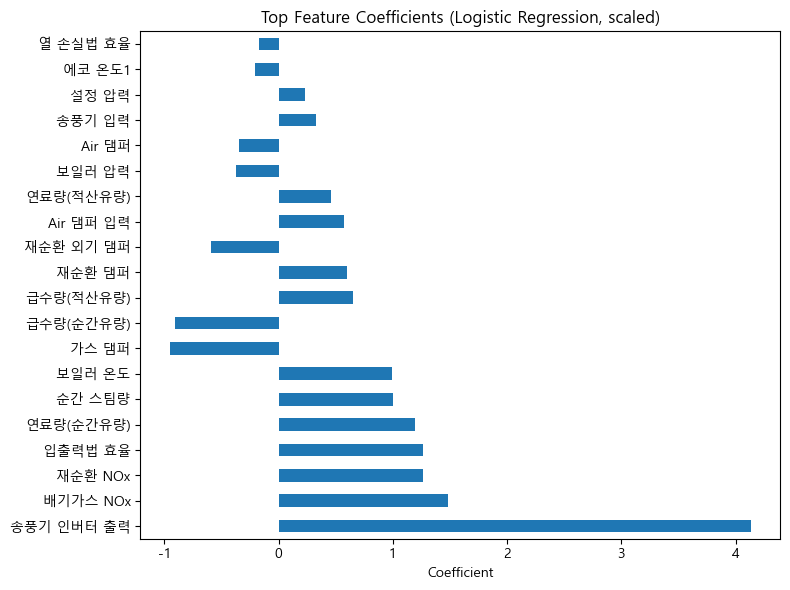

In [ ]:
#import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

#결과의 한글 표기를 위한 작업
if platform.system() == 'Windows':
    font_name = 'Malgun Gothic'  
else:  #리눅스인 경우
    font_name = 'NanumGothic'

rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


# === 파이프라인: Imputer -> Scaler -> LogisticRegression ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logit", LogisticRegression(max_iter=MAX_ITER))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('=== Classification Report ===')
print(classification_report(y_test, y_pred))
print('=== Confusion Matrix ===')
print(confusion_matrix(y_test, y_pred))

# 계수 (스케일 기준)
logit = pipe.named_steps["logit"]
coef_series = pd.Series(logit.coef_[0], index=X.columns, name='coef (scaled space)')
coef_abs = coef_series.abs().sort_values(ascending=False)
display(coef_series.loc[coef_abs.head(20).index])

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
coef_series.loc[coef_abs.head(20).index].plot(kind='barh')
plt.title('Top Feature Coefficients (Logistic Regression, scaled)')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.show()
